# Exercise Sheet #2: Battleships (1/2)

### Probabilistic Machine Learning

- **Lecturer**: Prof. Philipp Hennig
- **Term**: SoSe 2020
- **Due Date**: Monday, 04 May 2020, 10am


<!--![battleship rules](https://upload.wikimedia.org/wikipedia/commons/e/e4/Battleships_Paper_Game.svg)-->

Over the course of two weeks, we will implement an agent that can play the pen-and-paper game _Battleships_. The goal of this exercise sheet is to find exact prior probabilities of getting a hit by enumeration, and to update to a posterior given observations of hits and misses. This week we will understand why we can't construct the agent with this approach.  

Next week we will use Monte Carlo techniques to build an agent that we can play against :). Stay tuned!

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

### **2.1** A priori probability for a hit with one boat

**Tasks**
1. Write a function that takes the length of a boat and that returns the prior probability to observe a hit.
2. Plot the prior for a carrier (length 5).


*Hint:* You can find this probability by enumerating all possible positions of the boat.

In [2]:
field_size = 10

_Note:_ Let `i` denote the _row_ index and `j` the _column_ index

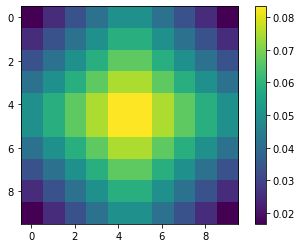

In [3]:
def boat_prior(boat_length, field_size):
    """
    Computes the prior probability to get a hit given the boat length and the size of the board.
    For a single-boat setup only.
    :param boat_length: Length of the boat, type: int
    :param field_size: size of the board, type: int
    
    :returns: np.ndarray of size (field_size, field_size) containing the probability of a hit for every field.
    """

    map_ = np.zeros((field_size, field_size))

    # Loop over all possible positions and orientations of the boat
    for x in range(field_size):
        for y in range(field_size):
            orientations = []
            if x <= field_size - boat_length:
                orientations.append('horizontal')
            if y <= field_size - boat_length:
                orientations.append('vertical')
            for o in orientations:
                d = np.hstack((np.zeros((boat_length, 1)), np.arange(boat_length)[:, None])
                              [::(-1 if o == 'horizontal' else 1)])
                boat = tuple((np.array([[x, y]]) + d).astype(int).T)
                map_[boat] += 1

    return map_ / map_.sum() * boat_length

L_carrier = 5
carrier_prior = boat_prior(L_carrier, field_size)
plt.imshow(carrier_prior)
plt.colorbar()

In [4]:
# Sanity check: carrier_prior should sum to the length of the boat
carrier_prior.sum()

5.000000000000001

### **2.2** Updating to a posterior given hit/miss observations

Let us define an `observation_board` that contains the observations. We use the following notation:  
    `0` unseen field  
    `-1` miss (water)  
    `1` hit  

**Task 1:** Write a function that takes as input the `observation_board` as well as the length of one boat, and that returns an array that contains the probability to get a hit at every coordinate of the field.

*Hint:* Again, this can be achieved by enumeration. Take care of all the constraints imposed by the `observation_board`!

In [5]:
def posterior_one_ship(observation_board, boat_length):
    """
    Computes the posterior probability to get a hit given an array of observed hits and misses as well as the boat length.
    For a single-boat setup only.
    :param observation_board: the board containing unobserved locations (0), misses (-1), and hits (1), type: np.ndarray
    :param boat_length: Length of the boat, type: int
    
    :returns: np.ndarray of the same size as the observation board containing the probability of a hit 
              for every field given the observations
    """
    
    map_ = np.zeros((field_size, field_size))
    
    # Loop over all possible positions and orientations of the boat
    for x in range(field_size):
        for y in range(field_size):
            orientations = []
            if x <= field_size - boat_length:
                orientations.append('horizontal')
            if y <= field_size - boat_length:
                orientations.append('vertical')
            for o in orientations:
                d = np.hstack((np.zeros((boat_length, 1)), np.arange(boat_length)[:, None])
                              [::(-1 if o == 'horizontal' else 1)])
                boat = tuple((np.array([[x, y]]) + d).astype(int).T)
                
                # - Check if boat position satisfies constraints -
                # Check if boat contains misses
                if -1 in observation_board[boat]:
                    continue
                
                # Check if board without boat contains hits
                observation_board_ = observation_board.copy()
                observation_board_[boat] = 2
                if 1 in observation_board_:
                    continue
                
                map_[boat] += 1
    
    if map_.sum() == 0:
        raise ValueError("What kind of boat is that?")
    return map_ / map_.sum() * boat_length

**Task 2:** Test your function on the following `observation_board`s (just run the cells)

In [6]:
# board 1: Only misses
obs_board_1 = np.zeros((field_size, field_size)); obs_board_1[[1, 2, 5, 8], [8, 3, 4, 6]] = -1

# board 2: a few misses, one hit
obs_board_2 = np.copy(obs_board_1); obs_board_2[7, 1] = 1

# board 3: a few misses, two hits
obs_board_3 = np.copy(obs_board_2); obs_board_3[6, 1] = 1

# board 4: two for one boat impossible hits: This should cause an error
obs_board_4 = np.copy(obs_board_2); obs_board_4[6, 2] = 1

<ipython-input-7-945bb33682b5>:13: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cmap.set_bad(color='w')


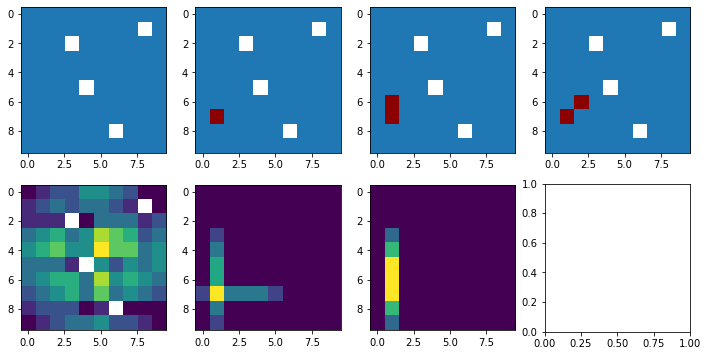

In [7]:
### VISUALIZATION
from matplotlib import colors

# making a custom discrete colormap for hits and misses
cmap_discrete = colors.ListedColormap(['white', 'C0','darkred'])
boundaries = [-1.5, -0.5, 0.5, 1.5]
norm = colors.BoundaryNorm(boundaries, cmap_discrete.N, clip=True)

# Plot the boards and the corresponding posterior
f, axs = plt.subplots(2, 4, figsize=(12,6))

cmap = matplotlib.cm.viridis  # Can be any colormap that you want after the cm
cmap.set_bad(color='w')

# board 1
post_1 = posterior_one_ship(obs_board_1, 5)
axs[0, 0].imshow(obs_board_1, cmap=cmap_discrete, norm=norm)
axs[1, 0].imshow(np.ma.masked_where(post_1 == 0, post_1), cmap=cmap)

# board 2
axs[0, 1].imshow(obs_board_2, cmap=cmap_discrete, norm=norm)
axs[1, 1].imshow(posterior_one_ship(obs_board_2, 5))

# board 3
axs[0, 2].imshow(obs_board_3, cmap=cmap_discrete, norm=norm)
axs[1, 2].imshow(posterior_one_ship(obs_board_3, 5))

# board 4
axs[0, 3].imshow(obs_board_4, cmap=cmap_discrete, norm=norm)
try:
    axs[1, 3].imshow(posterior_one_ship(obs_board_4, 5))
except:
    pass

In [11]:
# board 4 should raise an error
posterior_one_ship(obs_board_4, 5)

ValueError: What kind of boat is that?

### **2.3** Towards battleship with more than one boat
_Note: No coding required!_

Next week's assignment will deal with the full game of Battleships, which, according to the above rules, contains seven ships.

1. Think about how you would need to modify your above routines to compute  
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   (a) the prior over ship locations   
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   (b) the posterior over ship locations given hit/miss observations  
    by enumerating all states. Describe the changes you would need to make to your code.
2. Why will it be hard to compute the posterior with multiple boats?

1. (a) It is not enough to just sum up the individual priors, because this would ignore that two ships cannot overlap. This needs to be taken into account. The code could look something like:
```python
for x1, y1, o1 in board:
    for x2, y2, o2 in board:
        if not valid:
            continue
        for x3, y3, o3 in board:
            if not valid:
                continue
            for ...
```
1. (b) Here we need to check for each possible boats configuration whether there is a conflict, i.e. a miss inside a boat or a hit inside the water. The boat configurations could be generated like above.

2. For $7$ boats we have $7 \cdot 3 = 21$ nested for-loops, or $7$ times looping over the board twice (horizontal, vertical). This means instead of just enumerating `2 * board_length^2` possibilities (for `board_lenght=10` this is 200), we need to loop over `(2 * board_length^2) ^ 7` possibilities (in this case $= 200^7 = 1.28 \times 10^{16}$). This is not counting the checking for validity described above, which of course also needs to loop over the whole board each time.